In [110]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import json

import matplotlib.pyplot as plt


In [89]:
#extracting latest weather
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
	"latitude": [5.390770,5.392571,5.324686,5.323670 ],
	"longitude": [-6.505318,-6.427247, -6.502779,-6.427451],
	"start_date": "1940-01-01",
	"end_date": "2023-12-31",
	"daily": ["weather_code","temperature_2m_max", "temperature_2m_min","temperature_2m_mean", "precipitation_sum", "rain_sum"],
	"timezone": "GMT"
}
responses = openmeteo.weather_api(url, params=params)

In [90]:
# Processing locations. 
actual_weather =[]
for i in range(0,4):
    response = responses[i]
    print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_weather_code = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()
    daily_rain_sum = daily.Variables(5).ValuesAsNumpy()
    
    daily_data = {"date": pd.date_range(
    	start = pd.to_datetime(daily.Time(), unit = "s"),
    	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
    	freq = pd.Timedelta(seconds = daily.Interval()),
    	inclusive = "left"
    )}
    daily_data["weather_code"] = daily_weather_code
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
    daily_data["precipitation_sum"] = daily_precipitation_sum
    daily_data["rain_sum"] = daily_rain_sum

    actual_weather.append(daily_data)
actual_weather[0]

Coordinates 5.3778557777404785°E -6.481781005859375°N
Elevation 109.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 5.3778557777404785°E -6.40728759765625°N
Elevation 82.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 5.307557106018066°E -6.4764404296875°N
Elevation 97.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 5.307557106018066°E -6.4019775390625°N
Elevation 97.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


{'date': DatetimeIndex(['1940-01-01', '1940-01-02', '1940-01-03', '1940-01-04',
                '1940-01-05', '1940-01-06', '1940-01-07', '1940-01-08',
                '1940-01-09', '1940-01-10',
                ...
                '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
                '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
                '2023-12-30', '2023-12-31'],
               dtype='datetime64[ns]', length=30681, freq='D'),
 'weather_code': array([63., 61., 53., ..., 51., 51., 51.], dtype=float32),
 'temperature_2m_max': array([28.087   , 28.237   , 27.337   , ..., 35.424   , 33.823997,
        35.724   ], dtype=float32),
 'temperature_2m_min': array([21.036999, 21.337   , 20.487   , ..., 23.124   , 23.924002,
        23.424002], dtype=float32),
 'temperature_2m_mean': array([23.436998, 23.43492 , 22.797417, ..., 27.99275 , 27.77817 ,
        28.05525 ], dtype=float32),
 'precipitation_sum': array([nan, 5.3, 0.7, ..., 0.3, 0.5, 0.1], dtype=float

In [83]:
gps_location = len(actual_weather[3]["date"])
gps_location

30681

In [84]:
len(actual_weather[3]["weather_code"])

30681

In [91]:
weather_point = pd.DataFrame(actual_weather[0])
code_count = weather_point["weather_code"].nunique()
code_list = weather_point["weather_code"].unique().tolist()
code_list

[63.0, 61.0, 53.0, 3.0, 51.0, 65.0, 55.0, 2.0, 1.0, 0.0]

In [92]:
code_dict ={
    0:"no clouds",
    1:"clouds disolving",
    2:"sky unchanged",
    3: "clouds developping",
    61:"rain slight",
    63:"rain moderate",
    65:"rain heavy",
    51:"drizzle, slight",
    53:"drizzle, moderate",
    55:"drizzle, heavy"
}

code_dict.keys()

dict_keys([0, 1, 2, 3, 61, 63, 65, 51, 53, 55])

In [93]:
weather_point

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum
0,1940-01-01,63.0,28.087000,21.036999,23.436998,NaN,NaN
1,1940-01-02,61.0,28.237000,21.337000,23.434919,5.3,5.3
2,1940-01-03,53.0,27.337000,20.487000,22.797417,0.7,0.7
3,1940-01-04,3.0,28.437000,21.286999,23.839081,0.0,0.0
4,1940-01-05,51.0,29.386999,20.837000,24.401581,0.4,0.4
...,...,...,...,...,...,...,...
30676,2023-12-27,3.0,36.124001,23.774000,28.686495,0.0,0.0
30677,2023-12-28,51.0,35.773998,23.624001,28.355247,0.1,0.1
30678,2023-12-29,51.0,35.424000,23.124001,27.992750,0.3,0.3
30679,2023-12-30,51.0,33.823997,23.924002,27.778170,0.5,0.5


In [106]:
weather_point["precipitation_sum"].head(25)

0           NaN
1      5.300000
2      0.700000
3      0.000000
4      0.400000
5      0.600000
6      2.900000
7      1.900000
8      9.200001
9      8.600000
10     5.700000
11     3.700000
12     0.300000
13     1.900000
14     1.500000
15     0.600000
16     1.300000
17     0.500000
18     1.400000
19     0.300000
20     4.700000
21    10.099999
22     1.600000
23     8.700000
24     0.300000
Name: precipitation_sum, dtype: float32

In [107]:
monthly_max_temp = weather_point.groupby(weather_point["date"].dt.to_period('M')).agg({'temperature_2m_max':'max'})
monthly_max_temp = monthly_max_temp.reset_index()
monthly_max_temp

,date,temperature_2m_max
0,1940-01,31.337000
1,1940-02,31.786999
2,1940-03,32.286999
3,1940-04,31.837000
4,1940-05,32.137001
...,...,...
1003,2023-08,32.523998
1004,2023-09,32.473999
1005,2023-10,31.774000
1006,2023-11,32.624001


In [108]:
monthly_min_temp = weather_point.groupby(weather_point["date"].dt.to_period('M')).agg({'temperature_2m_min': "min"})
monthly_min_temp = monthly_min_temp.reset_index()
monthly_min_temp

,date,temperature_2m_min
0,1940-01,20.386999
1,1940-02,20.636999
2,1940-03,20.937000
3,1940-04,21.487000
4,1940-05,21.136999
...,...,...
1003,2023-08,21.374001
1004,2023-09,21.424002
1005,2023-10,21.724001
1006,2023-11,21.824001


In [97]:
monthly_mean_temp = weather_point.groupby(weather_point["date"].dt.to_period('M')).agg({'temperature_2m_mean': "mean"})
monthly_mean_temp

,temperature_2m_mean
date,
1940-01,24.107967
1940-02,24.813076
1940-03,25.053936
1940-04,25.159153
1940-05,24.884512
...,...
2023-08,25.007467
2023-09,24.937819
2023-10,25.018490


In [113]:
monthly_cumul_rain = weather_point.groupby(weather_point["date"].dt.to_period('M')).agg({'precipitation_sum': "sum"})
monthly_cumul_rain = monthly_cumul_rain.reset_index()
monthly_cumul_rain['month_number'] = monthly_cumul_rain['date'].dt.month
monthly_cumul_rain

,date,precipitation_sum,month_number
0,1940-01,80.200005,1
1,1940-02,92.599998,2
2,1940-03,115.400002,3
3,1940-04,165.100006,4
4,1940-05,136.800003,5
...,...,...,...
1003,2023-08,117.100006,8
1004,2023-09,229.800003,9
1005,2023-10,252.500000,10
1006,2023-11,107.599998,11


In [119]:
monthly_avg = monthly_cumul_rain.groupby('date')['precipitation_sum'].mean().reset_index()
monthly_avg

,date,precipitation_sum
0,1940-01,80.200005
1,1940-02,92.599998
2,1940-03,115.400002
3,1940-04,165.100006
4,1940-05,136.800003
...,...,...
1003,2023-08,117.100006
1004,2023-09,229.800003
1005,2023-10,252.500000
1006,2023-11,107.599998


ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of labels (12).

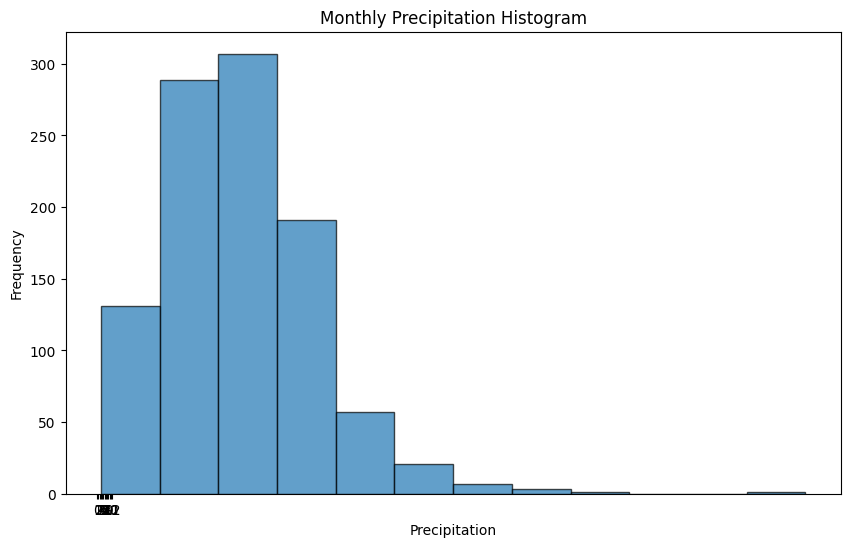

In [117]:
plt.figure(figsize=(10, 6))
plt.hist(monthly_cumul_rain['precipitation_sum'], bins=12, edgecolor='black', alpha=0.7)
plt.title('Monthly Precipitation Histogram')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.xticks(range(13), list(monthly_cumul_rain['month_number'].unique()))  
plt.show()

In [116]:
list(monthly_cumul_rain['month_number'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [104]:
monthly_rain_day = weather_point.groupby(weather_point["date"].dt.to_period('M')).agg({'precipitation_sum': lambda x: (x != 0).sum()})
monthly_rain_day = monthly_rain_day.reset_index()
monthly_rain_day

,date,precipitation_sum
0,1940-01,30
1,1940-02,29
2,1940-03,31
3,1940-04,30
4,1940-05,30
...,...,...
1003,2023-08,31
1004,2023-09,30
1005,2023-10,31
1006,2023-11,29
